# Libraries

In [1]:
!pip install mord
!pip install gensim
!pip install vaderSentiment

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=f1f64f09dbf97bcf539c642d62953ec54781055814fa39209612be172da93a24
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


In [2]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import exists
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from datetime import datetime
import statsmodels.api as sm
from mord import LogisticAT
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models import LdaModel
from gensim import corpora
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/data')

Mounted at /content/drive


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

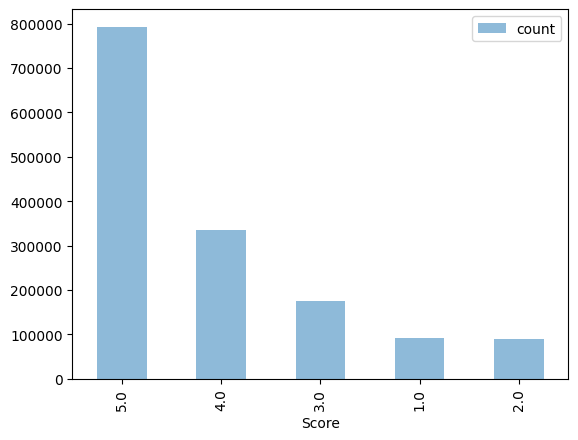


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [5]:
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['High_Helpfulness_Flag'] = (df['Helpfulness'] > 0.5).astype(int)
    df['Helpfulness_Bucket'] = np.where(df['Helpfulness'] == 0, 'none',
                                        np.where(df['Helpfulness'] > 0.7, 'high', 'medium'))
    df['Review_Age'] = df['Time'].apply(lambda x: (datetime.now() - datetime.fromtimestamp(x)).days if pd.notnull(x) else 0)
    df['Text_Length'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['Sentiment_Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
    user_review_counts = df['UserId'].value_counts()
    df['User_Review_Count'] = df['UserId'].map(user_review_counts)
    df['Sentiment_Helpfulness'] = df['Sentiment_Polarity'] * df['Helpfulness']
    df['Review_Age_Helpfulness'] = df['Review_Age'] * df['Helpfulness']

    # TF-IDF features with dimensionality reduction using TruncatedSVD
    tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'].fillna(''))
    svd = TruncatedSVD(n_components=50, random_state=42)
    tfidf_reduced = svd.fit_transform(tfidf_matrix)
    tfidf_features = pd.DataFrame(tfidf_reduced, columns=[f'svd_{i}' for i in range(tfidf_reduced.shape[1])])
    df = pd.concat([df.reset_index(drop=True), tfidf_features], axis=1)

    return df

#load data or process features if they don't already exist
if os.path.exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if os.path.exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")
else:
  #otherwise create those X_train and X_submission variables and files
    train = add_features_to(trainingSet)
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x']).rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Sample + Split into training and testing set

In [6]:
X = X_train.drop(columns=['Score']) #X contains all the features from X_train except the target variable score
y = X_train['Score'] #y represents the target variable, which will be used as the ground truth or labels for training and testing the model so it has the scores

#train-test split with stratification by score
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y,                 # split X and y into the training and testing
    test_size=0.25,       # 25% of the data goes into the test set
    random_state=42,      # for reproducibility
    stratify=y            # ensures equal distribution of star ratings
)

# Feature Selection

# Model Creation & Evaluation


In [7]:
#adjust the X_train and X_test by including only numerical columns
#as it'll cause the model to not perform well for generalizing
X_train_split_numeric = X_train_split.select_dtypes(include=[np.number])
X_test_split_numeric = X_test_split.select_dtypes(include=[np.number])

scaler = StandardScaler() #will standardize features by removing the mean and scaling to unit variance
X_train_scaled = scaler.fit_transform(X_train_split_numeric)  #scales the data by centering and normalizing each feature to have a mean of 0 and a standard deviation of 1
X_test_scaled = scaler.transform(X_test_split_numeric) #same scaling transformation as above

#convert the target variables into integer type
y_train_split = y_train_split.astype(int)
y_test_split = y_test_split.astype(int)

In [10]:
# Random Forest
rf_best = RandomForestClassifier(
    n_estimators=200, #provides a robust forest that can capture complex patterns in the data. less than this and it didnt do as well, and more and the tradeoff of time running wasnt worth it
    max_depth=20, #deep enough to capture important feature interactions while not being so deep as to cause overfitting.
    min_samples_split=2, #determines the minimum number of samples required to split an internal node. allows each node to split as long as there are at least two samples
    random_state=42, #fixed seed for reproducibility
    class_weight='balanced' #balanced class weights due to under- and over-representation in the dataset
)
rf_best.fit(X_train_scaled, y_train_split)
print("Random Forest Model Trained.")

rf_preds = rf_best.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_split, rf_preds)
print("Random Forest Classifier Accuracy:", rf_accuracy)

Random Forest Model Trained.
Random Forest Classifier Accuracy: 0.5641736863649094


In [8]:
# SGD Classifier
sgd_best = SGDClassifier(
    loss='log_loss', #allows the SGD Classifier to output probabilities, enabling its use in soft-voting ensembles where probabilistic outputs are combined
    alpha=1e-3, #regularization strength at a moderate level to prevent overfitting
    penalty='l1', #controls the type of regularization, l1 encourages sparsity by driving less important feature weights to zero
    max_iter=1000, #provides ample iterations for convergence
    random_state=42, #random seed for reproducibility
    class_weight='balanced'  #balanced class weights due to under- and over-representation in the dataset
)
sgd_best.fit(X_train_scaled, y_train_split)
print("SGD Classifier Model Trained.")

sgd_preds = sgd_best.predict(X_test_scaled)
sgd_accuracy = accuracy_score(y_test_split, sgd_preds)
print("SGD Classifier Accuracy:", sgd_accuracy)

SGD Classifier Model Trained.
SGD Classifier Accuracy: 0.559180903548269


In [9]:
# Ordinal Logistic Regression
ord_log_reg = LogisticAT()
ord_log_reg.fit(X_train_scaled, y_train_split)

ord_log_preds = np.argmax(ord_log_reg.predict_proba(X_test_scaled), axis=1) + 1  #convert to class labels (1-5)
ord_log_accuracy = accuracy_score(y_test_split, ord_log_preds)
print("Ordinal Logistic Regression Accuracy:", ord_log_accuracy)

Ordinal Logistic Regression Accuracy: 0.5619142770967533


Ensemble Model Accuracy on testing set = 0.5876968567550682


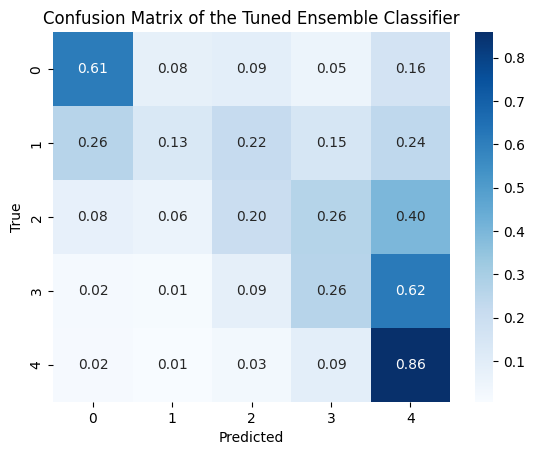

In [11]:
# Ensemble Model
#predict on the x test
rf_probs = rf_best.predict_proba(X_test_scaled)
sgd_probs = sgd_best.predict_proba(X_test_scaled)
ord_log_probs = ord_log_reg.predict_proba(X_test_scaled)

#soft voting
ensemble_probs = (ord_log_probs * 0.3 + sgd_probs * 0.2 + rf_probs * 0.4)
ensemble_predictions = np.argmax(ensemble_probs, axis=1) + 1 #convert to class labels (1-5)
ensemble_accuracy = accuracy_score(y_test_split, ensemble_predictions)
print("Ensemble Model Accuracy on testing set =", ensemble_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test_split, ensemble_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix of the Tuned Ensemble Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [12]:
#preprocessing submission data to make it numeric and drop the score column
X_submission_numeric = X_submission.select_dtypes(include=[np.number]).drop(columns=['Score'])
X_submission_scaled = scaler.transform(X_submission_numeric)  #fitted scaler

In [13]:
#get individual probabilities
ord_log_submission_probs = ord_log_reg.predict_proba(X_submission_scaled)
sgd_submission_probs = sgd_best.predict_proba(X_submission_scaled)
rf_submission_probs = rf_best.predict_proba(X_submission_scaled)

#then get the ensemble probability
submission_ensemble_probs = (
    ord_log_submission_probs * 0.3 +
    sgd_submission_probs * 0.2 +
    rf_submission_probs * 0.5
)

#get final predictions for submission with the ensemble
submission_predictions = np.argmax(submission_ensemble_probs, axis=1) + 1  #convert to class labels (1-5)

#create the submission file
submission = pd.DataFrame({
    'Id': X_submission['Id'],
    'Predicted_Score': submission_predictions
})
submission.to_csv("submission.csv", index=False)

print("Submission file created successfully.")

Submission file created successfully.
